In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import MinMaxInterval
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout

## Reading a FITS file

In [2]:
#img_path = '/home/viviane/BLF_training/Images/EUC_J/imageEUC_J-200001.fits'
img_path = '/home/vivianemm/BLF/Images/EUC_J/imageEUC_J-200001.fits'
fits.info(img_path)

Filename: /home/vivianemm/BLF/Images/EUC_J/imageEUC_J-200001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   (66, 66)   float32   


In [3]:
### using fits.getdata() --> np array
img_data = fits.getdata(img_path, ext=0)
print(img_data)

[[-9.76715930e-12  5.15664941e-12  1.09206437e-11 ... -5.59254899e-12
  -3.11408560e-12  4.89244192e-12]
 [-1.53540358e-11  1.29798325e-11 -2.45361175e-12 ...  7.96089583e-12
  -1.83813902e-11 -2.78579763e-12]
 [ 1.88017896e-12  9.41518478e-12  6.43359443e-13 ...  9.76120226e-13
   5.17626610e-12 -4.57186676e-12]
 ...
 [-6.50529934e-12  1.61818284e-11  7.76066971e-12 ... -5.27057131e-12
   5.44669128e-12  9.69319460e-13]
 [ 1.20240528e-11 -1.82952351e-12  2.04764972e-11 ...  1.14301635e-12
   1.23559182e-12 -1.11187286e-12]
 [ 2.80688558e-12 -8.62631754e-12  4.48427536e-12 ...  4.49563910e-12
   4.55615884e-12  3.62280019e-12]]


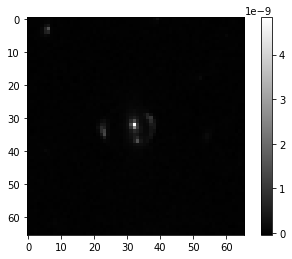

In [4]:
plt.figure()
plt.imshow(img_data, cmap='gray')
plt.colorbar()

In [5]:
# or using fits.open()  --> HDU object
hdul = fits.open(img_path)
img_data2 = hdul[0].data  # nparray
hdul[0].header
#hdul.close()

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                   66 / length of data axis 1                          
NAXIS2  =                   66 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
WCSAXES =                    2 / number of World Coordinate System axes         
CRPIX1  =                 33.5 / x-coordinate of reference pixel                
CRPIX2  =                 33.5 / y-coordinate of reference pixel                
CRVAL1  =                   0. / first axis value at reference pixel            
CRVAL2  =                   

## Creating a network

In [44]:
import gc
from keras.preprocessing.image import img_to_array
from imutils import paths
from sklearn.preprocessing import MultiLabelBinarizer
import cv2
import os
def get_data(IMAGE_DIMS):
    
    blf = pd.read_csv('Database/blf_complete.csv', comment="#")
    blf = blf.head(10000)

    imgs = []
    for path in blf['img_path_H']:
        #print(path)
        #hdul = fits.open(path)
        #img_data = hdul[0].data  # nparray
        #hdul.close()
        image = cv2.imread(path)
        if image is not None:
            image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
            Data1=image
            Data1[:,:,0]=image[:,:,2]
            Data1[:,:,2]=image[:,:,0]
            image=Data1
            image = img_to_array(image)            
        
        #data.append(image)

        #img_data = fits.getdata(path, ext=0)  # np array
        #gc.collect()
        
        #img_data *= 1/img_data.max()
        imgs.append(image)
    imgs = np.array(imgs)
    imgs = imgs / 255.0

    labels = np.array(blf['n_sources'])
    
    return imgs, labels

In [45]:
imgs, labels = get_data((66,66,1))

In [46]:
len(imgs)

10000

In [47]:
imgs[1].shape

(66, 66, 3)

In [48]:
i_list =[]
for i in range(0, len(imgs)):
    if imgs[i] is None:
        i_list.append(i)
        
labels = np.delete(labels, i_list, 0)
imgs = np.delete(imgs, i_list, 0)

In [49]:
len(imgs)

10000

In [50]:
imgs[1][0].shape

(66, 3)

In [51]:
l=[]
for i in range(0,imgs.shape[0]):
    l.append(imgs[i])
l=np.array(l)
l.shape


(10000, 66, 66, 3)

In [52]:
imgs = l

In [53]:
np.save("imagens.npy", imgs)
np.save("labels.npy", labels)
# imgs = np.load("imagens.npy")
# labels = np.load("labels.npy")

In [54]:
imgs, imgs_test, labels, labels_test = train_test_split(imgs, labels, test_size=0.1, random_state=42)
imgs, imgs_val, labels, labels_val = train_test_split(imgs, labels, test_size=0.30, random_state=42)
#imgs = imgs.reshape(imgs.shape + (1,) )
#imgs_test = imgs_test.reshape(imgs_test.shape + (1,))
#imgs_val = imgs_val.reshape(imgs_val.shape + (1,))
imgs_test.shape

(1000, 66, 66, 3)

In [55]:
def model():
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size = (3,3), input_shape = (66,66,3), activation = "relu"))
    model.add(Conv2D(32, kernel_size = (3,3), activation = "relu"))
    model.add(Conv2D(32, kernel_size = (3,3), activation = "relu"))
    model.add(Flatten())
    model.add(Dense(25, activation = "relu"))
    model.add(Dense(15, activation = "relu"))
    model.add(Dense(1, activation = "sigmoid"))
    
    return model

In [56]:
modelo = model()

In [57]:
#modelo.summary()

In [58]:
modelo.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [59]:
history = modelo.fit(imgs,labels, epochs=30, validation_data = (imgs_val, labels_val))


Train on 6300 samples, validate on 2700 samples
Epoch 1/30
6300/6300 [==============================] - 42s 7ms/step - loss: 0.4835 - accuracy: 0.8903 - val_loss: 0.3343 - val_accuracy: 0.9048
Epoch 2/30
6300/6300 [==============================] - 40s 6ms/step - loss: 0.3050 - accuracy: 0.8957 - val_loss: 0.3869 - val_accuracy: 0.9015
Epoch 3/30
6300/6300 [==============================] - 40s 6ms/step - loss: 0.2198 - accuracy: 0.9186 - val_loss: 0.5025 - val_accuracy: 0.8970
Epoch 4/30
6300/6300 [==============================] - 40s 6ms/step - loss: 0.1359 - accuracy: 0.9492 - val_loss: 0.6961 - val_accuracy: 0.8737
Epoch 5/30
6300/6300 [==============================] - 41s 6ms/step - loss: 0.0912 - accuracy: 0.9660 - val_loss: 0.9540 - val_accuracy: 0.8593
Epoch 6/30
6300/6300 [==============================] - 42s 7ms/step - loss: 0.0647 - accuracy: 0.9773 - val_loss: 0.8588 - val_accuracy: 0.8341
Epoch 7/30
6300/6300 [==============================] - 40s 6ms/step - loss: 0.05

KeyboardInterrupt: 

In [ ]:
plt.plot(np.arange(0, 30), history.history["loss"], label = "Erro de trainamento")
plt.plot(np.arange(0, 30), history.history["val_loss"], label = "Erro de validação")
plt.xlabel("Epoch")
plt.legend(loc="upper left")
plt.show()

In [ ]:
#plt.plot(np.arange(0, 30), history.history["acc"], label = "Erro de trainamento")
#plt.plot(np.arange(0, 30), history.history["val_acc"], label = "Erro de validação")
#plt.xlabel("Epoch")
#plt.legend(loc="upper left")
#plt.show()

In [ ]:
def model_alt():
    
    model = Sequential()
    model.add(Conv2D(55, kernel_size = (3,3), input_shape = (66,66,1), activation = "relu"))
    model.add(Conv2D(32, kernel_size = (3,3), activation = "relu"))
    model.add(Conv2D(52, kernel_size = (3,3), activation = "relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(25, activation = "relu"))
    model.add(Dense(15, activation = "relu"))
    model.add(Dense(1, activation = "sigmoid"))
    
    return model

In [ ]:
modelo_alt = model_alt()

In [ ]:
modelo_alt.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
history_alt = modelo_alt.fit(imgs,labels, epochs=30, validation_data = (imgs_val, labels_val))

In [ ]:
plt.plot(np.arange(0, 30), history_alt.history["loss"], label = "Loss modelo alt")
plt.plot(np.arange(0, 30), history.history["loss"], label = "Loss")
plt.xlabel("Epoch")
plt.legend(loc="upper left")
plt.show()

In [ ]:
plt.plot(np.arange(0, 30), history_alt.history["val_loss"], label = "val_loss alt")
plt.plot(np.arange(0, 30), history.history["val_loss"], label = "Val_loss")
plt.xlabel("Epoch")
plt.legend(loc="upper left")
plt.show()

In [ ]:
a = pd.read_csv('Database/blf_complete.csv', comment="#")
a.set_index(a['ID'])
a #['img_path_H'] #[213913]